In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

In [2]:
data = yf.download('GOOG',
                   start='2014-1-1',
                   end='2024-12-1',
                   progress=False)
df = data[["Adj Close", "Open", "Close", "High", "Low"]].round(3)
df = df.droplevel(1, axis=1)
df.head()

Price,Adj Close,Open,Close,High,Low
Date,,,,,
2014-01-02,27.625,27.782,27.724,27.839,27.603
2014-01-03,27.423,27.771,27.522,27.819,27.520
2014-01-06,27.729,27.721,27.829,27.867,27.558
2014-01-07,28.264,28.020,28.365,28.386,27.924
2014-01-08,28.322,28.543,28.424,28.576,28.226


In [3]:
df.count()

Price
Adj Close    2747
Open         2747
Close        2747
High         2747
Low          2747
dtype: int64

In [4]:
train_len = int(len(df)*0.8)
train_df = df[:train_len].Close.values.reshape(-1, 1)
test_df = df[train_len:].Close.values.reshape(-1, 1)

In [5]:
def tr_data(df, X_steps=10, y_steps=3):
    train_len = int(len(df)*0.8)
    train_df = df[:train_len].Close.values.reshape(-1, 1)
    test_df = df[train_len-X_steps:].Close.values.reshape(-1, 1)
    
    sc = MinMaxScaler(feature_range=(0,1))
    train_df_s = sc.fit_transform(train_df) 
    X_train = []
    y_train = []
    
    for i in range(X_steps, len(train_df_s)-y_steps+1):
        X_train.append(train_df_s[i-X_steps:i])
        y_train.append(train_df_s[i:i+y_steps])
    
    X_train = np.array(X_train)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    y_train = np.array(y_train)
    
    
    test_df_s = sc.transform(test_df)
    X_test = []
    y_test = []
    for i in range(X_steps, len(test_df_s)-y_steps+1):
        X_test.append(test_df_s[i-X_steps:i])
        y_test.append(test_df_s[i:i+y_steps])
    
    X_test = np.array(X_test)
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_test = np.array(y_test)
    
    return X_train, X_test, y_train, y_test, sc 
        
    


In [19]:
X_train, X_test, y_train, y_test, sc = tr_data(df, 10, 3)

In [20]:
print('X_train size: ',X_train.shape, 
      '\nX_test size: ',X_test.shape, 
      '\ny_train size: ',y_train.shape, 
      '\ny_test size: ', y_test.shape,)

X_train size:  (2185, 10, 1) 
X_test size:  (548, 10, 1) 
y_train size:  (2185, 3, 1) 
y_test size:  (548, 3, 1)


In [45]:
!pip install keras-tuner

In [47]:
import keras_tuner as kt

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.SimpleRNN(units=hp.Int('layer_1', min_value=50, max_value=200, step=50), return_sequences=True))
    model.add(keras.layers.SimpleRNN(units=hp.Int('layer_2', min_value=50, max_value=200, step=50), return_sequences=True))
    model.add(keras.layers.SimpleRNN(units=hp.Int('layer_3', min_value=50, max_value=200, step=50)))
    model.add(keras.layers.Dense(units=hp.Int('layer_4', min_value=50, max_value=200, step=50), activation='relu'))
    model.add(keras.layers.Dense(3))
    
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mse'])
    return model

In [53]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="mse",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [54]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}
layer_4 (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 200, 'step': 50, 'sampling': 'linear'}


In [55]:
tuner.search(X_train,y_train,  validation_split=0.2, epochs=15)

Trial 3 Complete [00h 00m 12s]
val_mse: 0.007594025693833828

Best val_mse So Far: 0.0024726189440116286
Total elapsed time: 00h 00m 41s


In [63]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 10, 100)        │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 10, 50)         │         7,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,003 (277.36 KB)

 Trainable params: 71,003 (277.36 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
history_rnn = best_model.fit(X_train, y_train, epochs=50,  validation_split=0.2)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0296 - mse: 0.0021 - val_loss: 0.0443 - val_mse: 0.0033
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - mse: 2.4877e-04 - val_loss: 0.0612 - val_mse: 0.0050
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - mse: 1.3388e-04 - val_loss: 0.0379 - val_mse: 0.0021
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - mse: 1.5707e-04 - val_loss: 0.0694 - val_mse: 0.0062
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - mse: 1.6677e-04 - val_loss: 0.0491 - val_mse: 0.0033
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - mse: 1.2804e-04 - val_loss: 0.0289 - val_mse: 0.0013
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - mse: 1.2350e-04 - val_loss: 0.0397 - val_mse: 0.0023
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - mse: 1.0074e-04 - val_loss: 0.0766 - val_mse: 0.0074
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

In [66]:
rnn_pred = best_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [65]:
best_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0311 - mse: 0.0016 


[0.03687308728694916, 0.0022755973041057587]

In [68]:
def prediction_plot(predictions):
  fig, ax = plt.subplots()
  ax.plot(df[:train_len].index[:len(y_test)],
          sc.inverse_transform(y_test[:, 0].reshape(-1, 1)), label="Real")
  ax.plot(df[train_len:].index[:len(y_test)],
          sc.inverse_transform(predictions[:, 0].reshape(-1, 1)), label="Prediction")

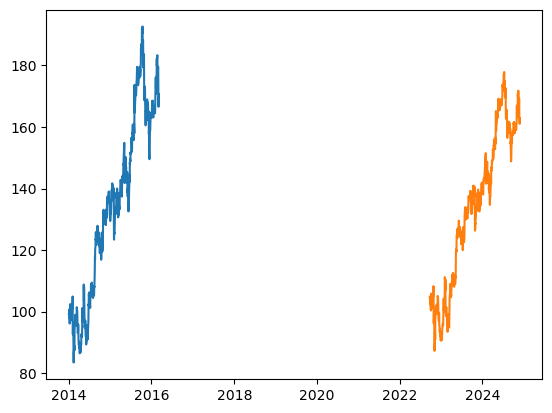

In [69]:
prediction_plot(rnn_pred)

In [ ]:
lstm.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [30]:
lstm_history = lstm.fit(X_train, y_train, validation_split=0.2, epochs=150)

Epoch 1/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 2/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.7578e-04 - mse: 2.7578e-04 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 3/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.0261e-04 - mse: 3.0261e-04 - val_loss: 0.0090 - val_mse: 0.0090
Epoch 4/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.0802e-04 - mse: 3.0802e-04 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 5/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.8810e-04 - mse: 2.8810e-04 - val_loss: 0.0074 - val_mse: 0.0074
Epoch 6/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.1882e-04 - mse: 3.1882e-04 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 7/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.0036e-04 - mse: 3.0036e-04 - val_loss: 0.0075 - val_mse: 0.0075
Epoch 8/150
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.7950e-04 - mse: 2.7950e-04 - val_loss: 0.0094 - val_mse: 0.0094


KeyboardInterrupt: 